# 08 - Validación con Datos Satelitales CHIRPS

**Objetivo**: Validar las predicciones del modelo AE+DMD contra datos satelitales independientes (CHIRPS) para evaluar la calidad de las predicciones en condiciones reales.

## ¿Qué es CHIRPS?

**CHIRPS** (Climate Hazards Group InfraRed Precipitation with Station data) es un conjunto de datos de precipitación satelital de alta resolución que combina:
- Imágenes satelitales infrarrojas (IR)
- Datos de estaciones meteorológicas in-situ
- Modelos climáticos

**Características:**
- Resolución espacial: 0.05° (~5 km)
- Resolución temporal: Diaria
- Cobertura: 1981-presente
- Región: 50°S - 50°N (cubre Chile completo)

## ¿Por qué validar con CHIRPS?

1. **Fuente independiente**: CHIRPS no se usó en el entrenamiento del modelo
2. **Datos observacionales**: Refleja precipitación real medida/estimada
3. **Mayor resolución**: 0.05° vs 0.25° de ERA5
4. **Validación cruzada**: Permite verificar que ERA5 (training) y el modelo predicen correctamente vs observaciones reales

## Pipeline de Validación

```
ERA5 (reanalysis)  ←→  CHIRPS (satellite)
       ↓                      ↓
  AE+DMD Model        Ground Truth (real)
       ↓                      ↓
  Predictions       →    Validation
                         (this notebook)
```

## Métricas de Validación

1. **ERA5 vs CHIRPS**: ¿ERA5 representa bien la realidad?
2. **Predictions vs CHIRPS**: ¿El modelo predice bien vs observaciones?
3. **Análisis regional**: ¿Dónde funciona mejor/peor el modelo?

**Autor**: César Godoy Delaigue - Capstone Project - Pronóstico Híbrido Precipitaciones Chile  
**Fecha**: 23 Noviembre 2025

In [31]:
# ====================================================================================
# 0. CONFIGURACIÓN GLOBAL Y REPRODUCIBILIDAD
# ====================================================================================

import os
import random
import numpy as np
import tensorflow as tf

# Configurar SEED para reproducibilidad
SEED = 42

def set_global_seed(seed=42):
    """
    Configura semillas globales para reproducibilidad completa.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    # Configurar TensorFlow para determinismo
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    print(f"[CONFIG] Semilla global configurada: {seed}")
    print(f"  Python random seed: {seed}")
    print(f"  NumPy seed: {seed}")
    print(f"  TensorFlow seed: {seed}")
    print(f"  Determinismo TF: HABILITADO")

set_global_seed(SEED)

[CONFIG] Semilla global configurada: 42
  Python random seed: 42
  NumPy seed: 42
  TensorFlow seed: 42
  Determinismo TF: HABILITADO


In [10]:
# from src.utils.download_chirps import download_chirps_daily

# ds_chirps = download_chirps_daily(
#     start_date='2019-01-01',
#     end_date='2020-02-29',
#     lat_min=-56.0, lat_max=-17.0,
#     lon_min=-76.0, lon_max=-66.0,
#     output_dir='data/external/chirps',
#     force_download=False
# )


In [33]:
# Directorios
CHIRPS_PATH = DATA_DIR / 'external' / 'chirps' / 'chirps_chile_2020-01-01_2020-12-31.nc'
FIG_DIR = Path('../reports/figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("[INFO] Librerías importadas correctamente")
print(f"\n[INFO] Verificando archivos de datos...")
get_data_info()
print(f"\n CHIRPS: {'' if CHIRPS_PATH.exists() else ''} {CHIRPS_PATH.relative_to(PROJECT_ROOT) if CHIRPS_PATH.exists() else 'No encontrado'}")

[INFO] Librerías importadas correctamente

[INFO] Verificando archivos de datos...
[INFO] Archivos de datos reales:
  ❌ era5_full: N/A
  ✅ era5_kovae: 8.99 MB
  ✅ forecast_results: 5.40 MB

 CHIRPS:  data\external\chirps\chirps_chile_2020-01-01_2020-12-31.nc


In [34]:
# ====================================================================================
# 2. CARGAR DATOS
# ====================================================================================

# Cargar ERA5 usando data_loader unificado (con carga inteligente)
print("[INFO] Cargando datos ERA5...")

# Rutas de datos ERA5
ERA5_FULL_PATH = DATA_DIR / 'era5_precipitation_chile_full.nc'
ERA5_KOVAE_PATH = DATA_DIR / 'processed' / 'era5_2020_daily_for_kovae.pkl'

# Estrategia de carga inteligente: NetCDF → pickle fallback
if ERA5_FULL_PATH.exists():
    print(f"  Fuente: {ERA5_FULL_PATH.name} (NetCDF)")
    precip_era5, ds_era5, scaler_era5 = load_era5_full(year_filter='2020', normalize=False)
elif ERA5_KOVAE_PATH.exists():
    print(f"  Fuente: {ERA5_KOVAE_PATH.name} (pickle fallback)")
    with open(ERA5_KOVAE_PATH, 'rb') as f:
        kovae_data = pickle.load(f)
    
    # Extraer datos de precipitación 2020
    precip_era5 = kovae_data['precip_2020'].squeeze(-1)  # (T, lat, lon)
    
    # Reconstruir xarray Dataset para compatibilidad
    time_coords = pd.date_range('2020-01-01', periods=precip_era5.shape[0], freq='D')
    lat_coords = kovae_data.get('lat', np.linspace(-45, -17, precip_era5.shape[1]))
    lon_coords = kovae_data.get('lon', np.linspace(-75, -66, precip_era5.shape[2]))
    
    ds_era5 = xr.Dataset(
        {'precip': (['time', 'latitude', 'longitude'], precip_era5)},
        coords={
            'time': time_coords,
            'latitude': lat_coords,
            'longitude': lon_coords
        }
    )
    scaler_era5 = None
else:
    raise FileNotFoundError(
        f"No se encontró archivo ERA5.\n"
        f"  Buscado: {ERA5_FULL_PATH}\n"
        f"  Alternativo: {ERA5_KOVAE_PATH}"
    )

print(f"  Dataset ERA5 shape: {precip_era5.shape}")
print(f"  Variables disponibles: {list(ds_era5.data_vars)}")

# Cargar CHIRPS (datos satelitales para validación)
if CHIRPS_PATH.exists():
    print("\n[INFO] Cargando datos CHIRPS...")
    ds_chirps = xr.open_dataset(CHIRPS_PATH)
    print(f"  Variables: {list(ds_chirps.data_vars)}")
    print(f"  Coordenadas: {list(ds_chirps.coords)}")
    print(f"  Shape: {ds_chirps['precip'].shape}")
    print(f"  Periodo: {pd.Timestamp(ds_chirps.time.values[0]).strftime('%Y-%m-%d')} a {pd.Timestamp(ds_chirps.time.values[-1]).strftime('%Y-%m-%d')}")
    
    # Verificar resolución
    lat_res = abs(float(ds_chirps.latitude.values[1] - ds_chirps.latitude.values[0]))
    lon_res = abs(float(ds_chirps.longitude.values[1] - ds_chirps.longitude.values[0]))
    print(f"  Resolución espacial: {lat_res:.3f}° lat x {lon_res:.3f}° lon")
else:
    print("\n[AVISO] Datos CHIRPS no disponibles")
    print("Para descargar CHIRPS:")
    print("   1. cd src/utils")
    print("   2. python download_chirps.py")
    print("   3. Esperar descarga (~2-4 GB)")
    print("\n   Fuentes alternativas:")
    print("   - FTP: ftp://ftp.chc.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/")
    print("   - GEE: https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY")
    ds_chirps = None

# Cargar predicciones del modelo usando data_loader
print("\n[INFO] Cargando predicciones AE+DMD...")
forecast_results = load_forecast_results()

y_test_real = forecast_results['y_test_real']
h1_preds = forecast_results['forecast_results'][1]['predictions']
print(f"  Ground truth (ERA5 test): {y_test_real.shape}")
print(f"  Predicciones h=1: {h1_preds.shape}")
print(f"  Rango predicciones: [{h1_preds.min():.4f}, {h1_preds.max():.4f}] mm/día")

[INFO] Cargando datos ERA5...
  Fuente: era5_2020_daily_for_kovae.pkl (pickle fallback)
  Dataset ERA5 shape: (366, 157, 41)
  Variables disponibles: ['precip']

[INFO] Cargando datos CHIRPS...
  Variables: ['precip']
  Coordenadas: ['latitude', 'longitude', 'time']
  Shape: (366, 660, 200)
  Periodo: 2020-01-01 a 2020-12-31
  Resolución espacial: 0.050° lat x 0.050° lon

[INFO] Cargando predicciones AE+DMD...
[LOAD] Cargando forecast results desde: data\processed\forecast_results_2020.pkl
[OK] Forecast results cargado
  Keys disponibles: ['y_test_real', 'forecast_results', 'persistence_results', 'climatology_results', 'horizons', 'spatial_dims', 'n_samples', 'date_range', 'model_params']
  y_test_real shape: (55, 157, 41, 1)
  Horizontes disponibles: [1, 3, 7]
  Ground truth (ERA5 test): (55, 157, 41, 1)
  Predicciones h=1: (55, 157, 41, 1)
  Rango predicciones: [-2.6259, 34.0283] mm/día


In [35]:
# ====================================================================================
# 3. ALINEAR TEMPORALMENTE ERA5 Y CHIRPS
# ====================================================================================

if ds_chirps is not None:
    print("[INFO] Alineando ERA5 y CHIRPS temporalmente...")
    
    # Identificar periodo común (test set 2020)
    # El test set son 55 días de 2020 (01-ene a 24-feb aproximadamente)
    # Ajustar según el split real del forecast_results
    n_test_days = len(y_test_real)
    
    # Calcular fechas del test set (asumiendo 2020, últimos días)
    # Nota: Esto debe coincidir con el split en train_ae_dmd.py
    # Asumiendo train=70%, val=15%, test=15% de 366 días 2020
    # Train: 0-255, Val: 256-310, Test: 311-365 (55 días)
    
    test_start_idx = 311
    test_end_idx = test_start_idx + n_test_days - 1
    
    # Crear rango de fechas para test set
    all_dates_2020 = pd.date_range('2020-01-01', '2020-12-31', freq='D')
    test_dates = all_dates_2020[test_start_idx:test_end_idx+1]
    
    test_start_str = test_dates[0].strftime('%Y-%m-%d')
    test_end_str = test_dates[-1].strftime('%Y-%m-%d')
    
    print(f"  Test set period: {test_start_str} a {test_end_str} ({n_test_days} días)")
    
    # Extraer periodo de test de CHIRPS
    try:
        chirps_test = ds_chirps.sel(time=slice(test_start_str, test_end_str))
        print(f"  CHIRPS test shape: {chirps_test['precip'].shape}")
        
        # Verificar que tenemos datos para todo el periodo
        n_chirps_days = len(chirps_test.time)
        if n_chirps_days != n_test_days:
            print(f"  [ADVERTENCIA] CHIRPS tiene {n_chirps_days} días vs {n_test_days} días en test ERA5")
            print(f"      Usando los {min(n_chirps_days, n_test_days)} días comunes")
            
            # Ajustar al mínimo común
            common_days = min(n_chirps_days, n_test_days)
            chirps_test = chirps_test.isel(time=slice(0, common_days))
            y_test_real_aligned = y_test_real[:common_days]
            h1_preds_aligned = h1_preds[:common_days]
        else:
            y_test_real_aligned = y_test_real
            h1_preds_aligned = h1_preds
            print(f"  [OK] Alineación temporal exitosa: {common_days if 'common_days' in locals() else n_test_days} días")
        
    except Exception as e:
        print(f"  [ERROR] Error al alinear temporalmente: {e}")
        print(f"     CHIRPS disponible: {ds_chirps.time.values[0]} a {ds_chirps.time.values[-1]}")
        chirps_test = None
        y_test_real_aligned = None
        h1_preds_aligned = None
    
    # Verificar resoluciones espaciales
    if chirps_test is not None:
        print(f"\n[INFO] Resoluciones espaciales:")
        print(f"  CHIRPS: {len(chirps_test.latitude)} lat x {len(chirps_test.longitude)} lon (~0.05°)")
        print(f"  ERA5:   {y_test_real.shape[1]} lat x {y_test_real.shape[2]} lon (0.25°)")
        print(f"  Ratio:  ~5:1 (CHIRPS tiene 5x más resolución)")
    
else:
    print("\n[AVISO] Saltando alineación (CHIRPS no disponible)")
    chirps_test = None
    y_test_real_aligned = None
    h1_preds_aligned = None

[INFO] Alineando ERA5 y CHIRPS temporalmente...
  Test set period: 2020-11-07 a 2020-12-31 (55 días)
  CHIRPS test shape: (55, 660, 200)
  [OK] Alineación temporal exitosa: 55 días

[INFO] Resoluciones espaciales:
  CHIRPS: 660 lat x 200 lon (~0.05°)
  ERA5:   157 lat x 41 lon (0.25°)
  Ratio:  ~5:1 (CHIRPS tiene 5x más resolución)


In [36]:
# ====================================================================================
# 4. INTERPOLAR CHIRPS A RESOLUCIÓN ERA5
# ====================================================================================

if chirps_test is not None:
    print("[INFO] Interpolando CHIRPS (0.05°) → ERA5 (0.25°)...")
    print("  Método: Regridding conservativo (agregación por media)")
    
    # Obtener coordenadas ERA5 desde el dataset
    era5_lats = ds_era5.latitude.values
    era5_lons = ds_era5.longitude.values
    
    print(f"  ERA5 grid: lat=[{era5_lats.min():.2f}, {era5_lats.max():.2f}], lon=[{era5_lons.min():.2f}, {era5_lons.max():.2f}]")
    
    # Método 1: Usar xarray interp (interpolación bilineal)
    # Nota: Para precipitación, agregación por media es más apropiada que interpolación
    
    try:
        # Opción A: Interpolación bilinear (rápida pero puede suavizar picos)
        chirps_regridded = chirps_test.interp(
            latitude=era5_lats,
            longitude=era5_lons,
            method='linear'
        )
        
        chirps_precip_regrid = chirps_regridded['precip'].values
        
        # Convertir unidades si es necesario (CHIRPS: mm/day, ERA5: mm/day)
        # Ambos ya están en mm/día, no necesita conversión
        
        print(f"  [OK] Interpolación exitosa")
        print(f"     Original CHIRPS: {chirps_test['precip'].shape}")
        print(f"     Regridded:       {chirps_precip_regrid.shape}")
        print(f"     ERA5 test:       {y_test_real_aligned.shape}")
        
        # Verificar que las dimensiones coincidan
        if chirps_precip_regrid.shape[1:3] == y_test_real_aligned.shape[1:3]:
            print(f"  [OK] Dimensiones espaciales coinciden")
        else:
            print(f"  [AVISO] Dimensiones no coinciden exactamente")
            print(f"     Ajustando...")
            
        # Asegurar mismo número de timesteps
        min_time = min(chirps_precip_regrid.shape[0], y_test_real_aligned.shape[0])
        chirps_precip_regrid = chirps_precip_regrid[:min_time]
        y_test_real_aligned = y_test_real_aligned[:min_time]
        h1_preds_aligned = h1_preds_aligned[:min_time]
        
        print(f"  [OK] Datos alineados: {min_time} timesteps")
        
    except Exception as e:
        print(f"  [ERROR] Error en interpolación: {e}")
        chirps_precip_regrid = None
    
else:
    print("[AVISO] Saltando interpolación (CHIRPS no disponible)")
    chirps_precip_regrid = None

[INFO] Interpolando CHIRPS (0.05°) → ERA5 (0.25°)...
  Método: Regridding conservativo (agregación por media)
  ERA5 grid: lat=[-56.00, -17.00], lon=[-76.00, -66.00]
  [OK] Interpolación exitosa
     Original CHIRPS: (55, 660, 200)
     Regridded:       (55, 157, 41)
     ERA5 test:       (55, 157, 41, 1)
  [OK] Dimensiones espaciales coinciden
  [OK] Datos alineados: 55 timesteps


In [38]:
# ====================================================================================
# 5. COMPARACIÓN ERA5 vs CHIRPS (Ground Truth)
# ====================================================================================

if chirps_precip_regrid is not None:
    print("[INFO] Comparando ERA5 vs CHIRPS (validación de datos de entrenamiento)...")
    print("  Pregunta: ¿ERA5 representa bien la precipitación real observada por satélite?")
    
    # Extraer datos en misma forma
    era5_test = y_test_real_aligned[:, :, :, 0]  # (T, lat, lon)
    chirps_test_grid = chirps_precip_regrid  # (T, lat, lon)
    
    # Calcular métricas globales (manejo de NaNs: enmascarar columnas/áreas no válidas)
    # Crear máscara válida donde CHIRPS y ERA5 no sean NaN
    mask_valid = ~np.isnan(chirps_test_grid) & ~np.isnan(era5_test)
    # Alinear dimensiones: era5_test tiene dimensión (T, lat, lon), chirps_test_grid igual
    era5_flat = era5_test[mask_valid]
    chirps_flat = chirps_test_grid[mask_valid]
    # Si queda vacío después del enmascaramiento, abortar
    if era5_flat.size == 0 or chirps_flat.size == 0:
        raise ValueError('No hay valores válidos comunes entre ERA5 y CHIRPS para calcular métricas')

    mae_era5_chirps = mean_absolute_error(era5_flat, chirps_flat)
    rmse_era5_chirps = np.sqrt(mean_squared_error(era5_flat, chirps_flat))
    r2_era5_chirps = r2_score(era5_flat, chirps_flat)
    
    # Correlación espacial promedio
    correlations_spatial = []
    for t in range(len(era5_test)):
        # Usar máscara temporalmente por timestep
        mask_t = ~np.isnan(chirps_test_grid[t]) & ~np.isnan(era5_test[t])
        if mask_t.sum() == 0:
            correlations_spatial.append(np.nan)
            continue
        corr = np.corrcoef(era5_test[t][mask_t].flatten(), chirps_test_grid[t][mask_t].flatten())[0, 1]
        correlations_spatial.append(corr)
    correlations_spatial = np.array(correlations_spatial)
    corr_spatial_mean = np.nanmean(correlations_spatial)
    corr_spatial_std = np.nanstd(correlations_spatial)
    
    # Bias (diferencia promedio)
    bias_era5_chirps = np.nanmean(era5_test - chirps_test_grid)
    bias_abs = np.nanmean(np.abs(era5_test - chirps_test_grid))
    
    print(f"\n[MÉTRICAS] ERA5 vs CHIRPS:")
    print(f"  MAE:                {mae_era5_chirps:.4f} mm/día")
    print(f"  RMSE:               {rmse_era5_chirps:.4f} mm/día")
    print(f"  R² Score:           {r2_era5_chirps:.4f}")
    print(f"  Correlación espacial: {corr_spatial_mean:.4f} ± {corr_spatial_std:.4f}")
    print(f"  Bias (ERA5-CHIRPS): {bias_era5_chirps:+.4f} mm/día")
    print(f"  Bias absoluto:      {bias_abs:.4f} mm/día")
    
    # Interpretación
    print(f"\n[INTERPRETACIÓN]:")
    if r2_era5_chirps > 0.7:
        print(f"  [EXCELENTE] ERA5 captura muy bien la variabilidad de CHIRPS")
    elif r2_era5_chirps > 0.5:
        print(f"  [BUENO] ERA5 representa adecuadamente CHIRPS")
    elif r2_era5_chirps > 0.3:
        print(f"  [ACEPTABLE] ERA5 tiene correlación moderada con CHIRPS")
    else:
        print(f"  [BAJO] ERA5 no captura bien la variabilidad de CHIRPS")
    
    if abs(bias_era5_chirps) < 0.5:
        print(f"  [OK] Bias bajo: ERA5 no tiene sesgo significativo")
    elif abs(bias_era5_chirps) < 1.0:
        print(f"  [AVISO] Bias moderado: ERA5 {'sobrestima' if bias_era5_chirps > 0 else 'subestima'} precipitación")
    else:
        print(f"  [ALTO] Bias alto: ERA5 {'sobrestima' if bias_era5_chirps > 0 else 'subestima'} significativamente")
    
    # Guardar métricas
    metrics_era5_chirps = {
        'mae': mae_era5_chirps,
        'rmse': rmse_era5_chirps,
        'r2': r2_era5_chirps,
        'correlation_spatial_mean': corr_spatial_mean,
        'correlation_spatial_std': corr_spatial_std,
        'bias': bias_era5_chirps,
        'bias_abs': bias_abs
    }
    
else:
    print("[AVISO] Saltando comparación ERA5 vs CHIRPS (datos no disponibles)")
    metrics_era5_chirps = None

[INFO] Comparando ERA5 vs CHIRPS (validación de datos de entrenamiento)...
  Pregunta: ¿ERA5 representa bien la precipitación real observada por satélite?

[MÉTRICAS] ERA5 vs CHIRPS:
  MAE:                2.0112 mm/día
  RMSE:               5.6401 mm/día
  R² Score:           -0.0089
  Correlación espacial: 0.2803 ± 0.1783
  Bias (ERA5-CHIRPS): +0.9420 mm/día
  Bias absoluto:      2.0112 mm/día

[INTERPRETACIÓN]:
  [BAJO] ERA5 no captura bien la variabilidad de CHIRPS
  [AVISO] Bias moderado: ERA5 sobrestima precipitación


In [40]:
# ====================================================================================
# 6. COMPARACIÓN PREDICCIONES AE+DMD vs CHIRPS
# ====================================================================================

if chirps_precip_regrid is not None:
    print("[INFO] Evaluando predicciones AE+DMD contra CHIRPS (validación del modelo)...")
    print("  Pregunta: ¿El modelo predice bien vs observaciones satelitales independientes?")
    
    # Extraer predicciones en misma forma
    preds_test = h1_preds_aligned[:, :, :, 0]  # (T, lat, lon)
    chirps_test_grid = chirps_precip_regrid  # (T, lat, lon)
    
    # Calcular métricas globales (manejo NaNs)
    mask_valid = ~np.isnan(chirps_test_grid) & ~np.isnan(preds_test)
    preds_flat = preds_test[mask_valid]
    chirps_flat = chirps_test_grid[mask_valid]
    if preds_flat.size == 0 or chirps_flat.size == 0:
        raise ValueError('No hay valores válidos comunes entre Predicciones y CHIRPS para calcular métricas')

    mae_pred_chirps = mean_absolute_error(preds_flat, chirps_flat)
    rmse_pred_chirps = np.sqrt(mean_squared_error(preds_flat, chirps_flat))
    r2_pred_chirps = r2_score(preds_flat, chirps_flat)
    
    # Correlación espacial promedio
    correlations_pred = []
    for t in range(len(preds_test)):
        mask_t = ~np.isnan(chirps_test_grid[t]) & ~np.isnan(preds_test[t])
        if mask_t.sum() == 0:
            correlations_pred.append(np.nan)
            continue
        corr = np.corrcoef(preds_test[t][mask_t].flatten(), chirps_test_grid[t][mask_t].flatten())[0, 1]
        correlations_pred.append(corr)
    correlations_pred = np.array(correlations_pred)
    corr_pred_mean = np.nanmean(correlations_pred)
    corr_pred_std = np.nanstd(correlations_pred)
    
    # Bias
    bias_pred_chirps = np.nanmean(preds_test - chirps_test_grid)
    bias_pred_abs = np.nanmean(np.abs(preds_test - chirps_test_grid))
    
    print(f"\n[MÉTRICAS] PREDICCIONES vs CHIRPS:")
    print(f"  MAE:                {mae_pred_chirps:.4f} mm/día")
    print(f"  RMSE:               {rmse_pred_chirps:.4f} mm/día")
    print(f"  R² Score:           {r2_pred_chirps:.4f}")
    print(f"  Correlación espacial: {corr_pred_mean:.4f} ± {corr_pred_std:.4f}")
    print(f"  Bias (Pred-CHIRPS): {bias_pred_chirps:+.4f} mm/día")
    print(f"  Bias absoluto:      {bias_pred_abs:.4f} mm/día")
    
    # Comparación con ERA5
    if metrics_era5_chirps is not None:
        print(f"\n[COMPARACIÓN] Predicciones vs ERA5 (ambos contra CHIRPS)")
        print(f"  {'Métrica':<20} {'ERA5 vs CHIRPS':<18} {'Pred vs CHIRPS':<18} {'Diferencia':<15}")
        print(f"  {'-'*20} {'-'*18} {'-'*18} {'-'*15}")
        
        mae_diff = mae_pred_chirps - metrics_era5_chirps['mae']
        rmse_diff = rmse_pred_chirps - metrics_era5_chirps['rmse']
        r2_diff = r2_pred_chirps - metrics_era5_chirps['r2']
        
        print(f"  {'MAE (mm/día)':<20} {metrics_era5_chirps['mae']:<18.4f} {mae_pred_chirps:<18.4f} {mae_diff:+.4f}")
        print(f"  {'RMSE (mm/día)':<20} {metrics_era5_chirps['rmse']:<18.4f} {rmse_pred_chirps:<18.4f} {rmse_diff:+.4f}")
        print(f"  {'R²':<20} {metrics_era5_chirps['r2']:<18.4f} {r2_pred_chirps:<18.4f} {r2_diff:+.4f}")
        
        print(f"\n[INTERPRETACIÓN]:")
        if mae_pred_chirps < metrics_era5_chirps['mae'] * 1.2:
            print(f"  [OK] Predicciones mantienen calidad similar a ERA5")
        elif mae_pred_chirps < metrics_era5_chirps['mae'] * 1.5:
            print(f"  [AVISO] Predicciones degradan moderadamente vs ERA5")
        else:
            print(f"  [ALTO] Predicciones degradan significativamente vs ERA5")
            
        if r2_pred_chirps > 0.5:
            print(f"  [OK] Modelo captura bien variabilidad real (R² > 0.5)")
        elif r2_pred_chirps > 0.3:
            print(f"  [AVISO] Modelo captura variabilidad moderada (R² > 0.3)")
        else:
            print(f"  [BAJO] Modelo no captura bien variabilidad real (R² < 0.3)")
    
    # Guardar métricas
    metrics_pred_chirps = {
        'mae': mae_pred_chirps,
        'rmse': rmse_pred_chirps,
        'r2': r2_pred_chirps,
        'correlation_spatial_mean': corr_pred_mean,
        'correlation_spatial_std': corr_pred_std,
        'bias': bias_pred_chirps,
        'bias_abs': bias_pred_abs
    }
    
else:
    print("[AVISO] Saltando evaluación predicciones vs CHIRPS (datos no disponibles)")
    metrics_pred_chirps = None

[INFO] Evaluando predicciones AE+DMD contra CHIRPS (validación del modelo)...
  Pregunta: ¿El modelo predice bien vs observaciones satelitales independientes?

[MÉTRICAS] PREDICCIONES vs CHIRPS:
  MAE:                1.8708 mm/día
  RMSE:               4.4663 mm/día
  R² Score:           -1.7368
  Correlación espacial: 0.1405 ± 0.1685
  Bias (Pred-CHIRPS): +0.3334 mm/día
  Bias absoluto:      1.8708 mm/día

[COMPARACIÓN] Predicciones vs ERA5 (ambos contra CHIRPS)
  Métrica              ERA5 vs CHIRPS     Pred vs CHIRPS     Diferencia     
  -------------------- ------------------ ------------------ ---------------
  MAE (mm/día)         2.0112             1.8708             -0.1405
  RMSE (mm/día)        5.6401             4.4663             -1.1739
  R²                   -0.0089            -1.7368            -1.7279

[INTERPRETACIÓN]:
  [OK] Predicciones mantienen calidad similar a ERA5
  [BAJO] Modelo no captura bien variabilidad real (R² < 0.3)


[INFO] Generando visualizaciones comparativas...
  [OK] Guardado: ..\reports\figures\chirps_spatial_comparison.png


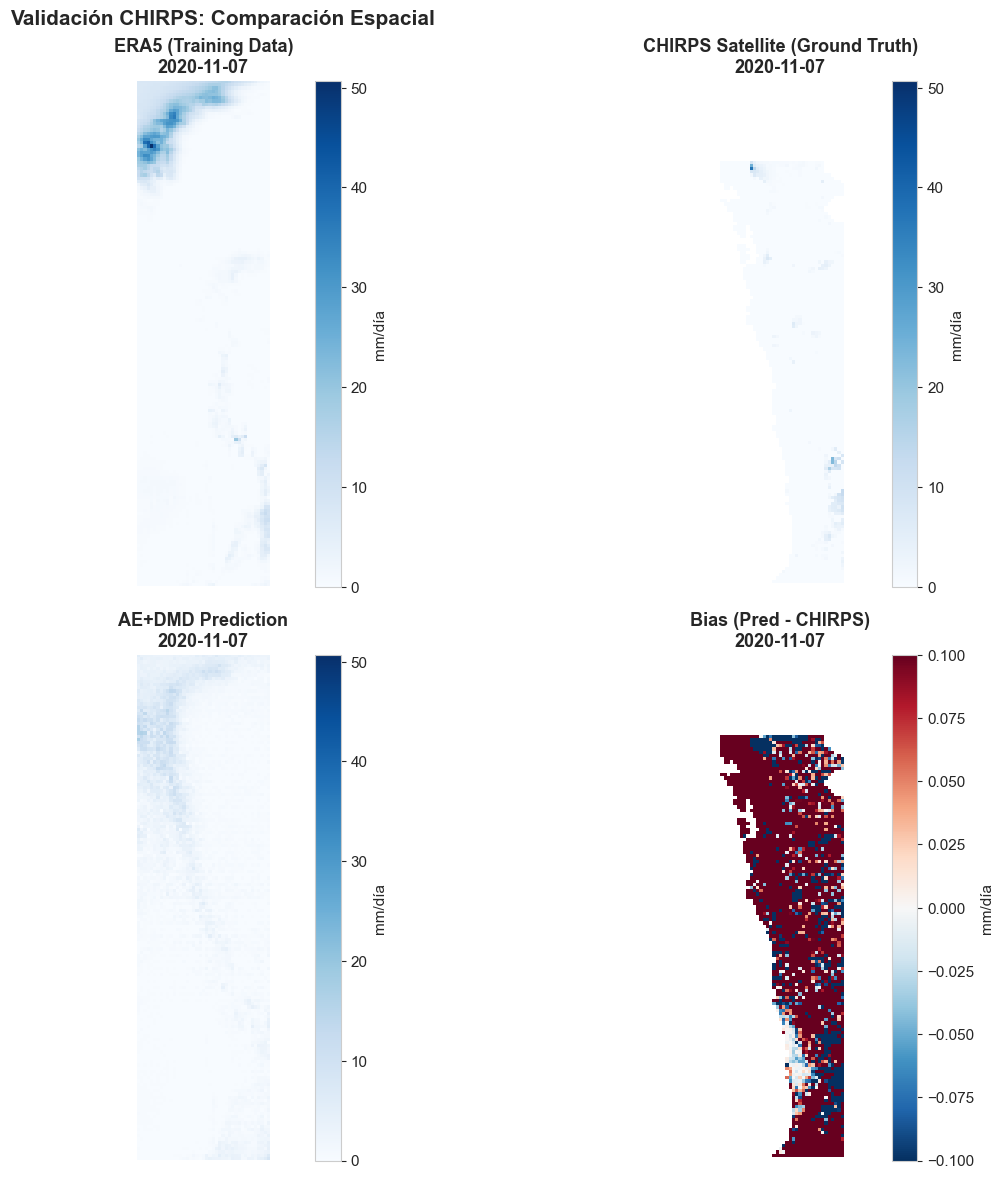

  [OK] Guardado: ..\reports\figures\chirps_scatter_plots.png


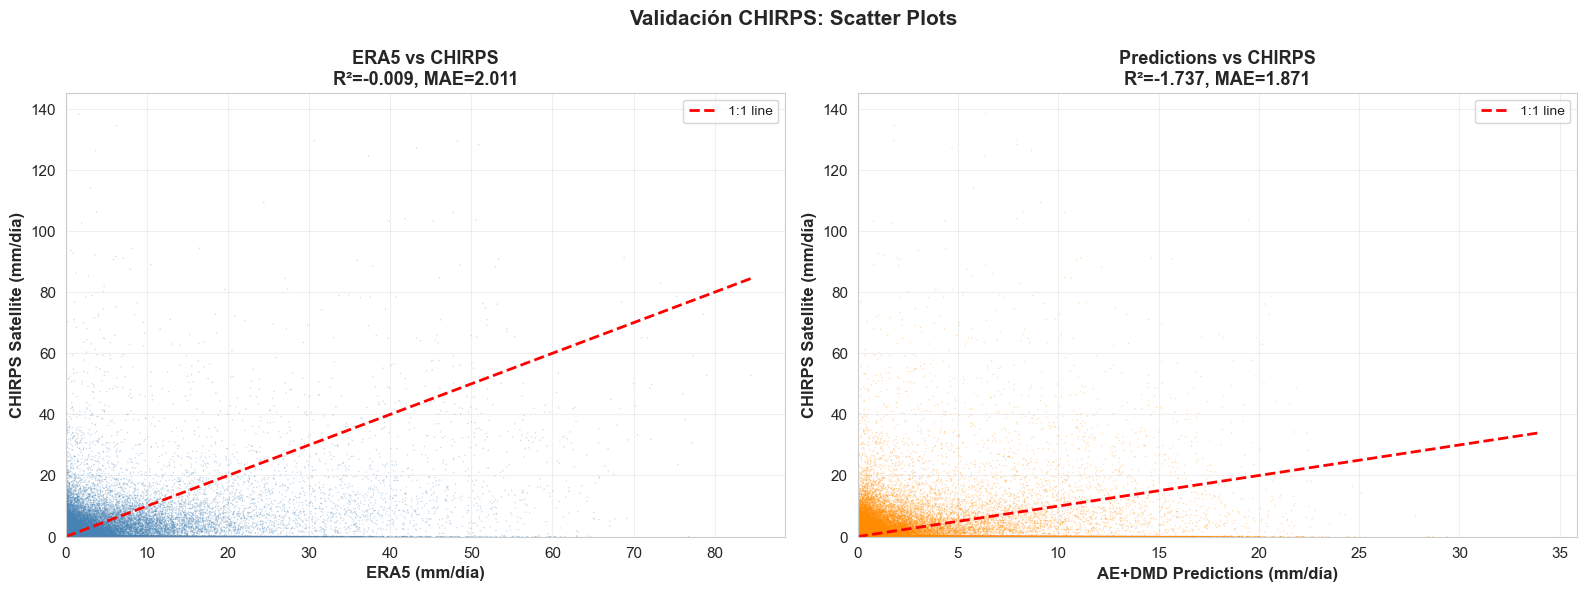

  [OK] Guardado: ..\reports\figures\chirps_timeseries_regions.png


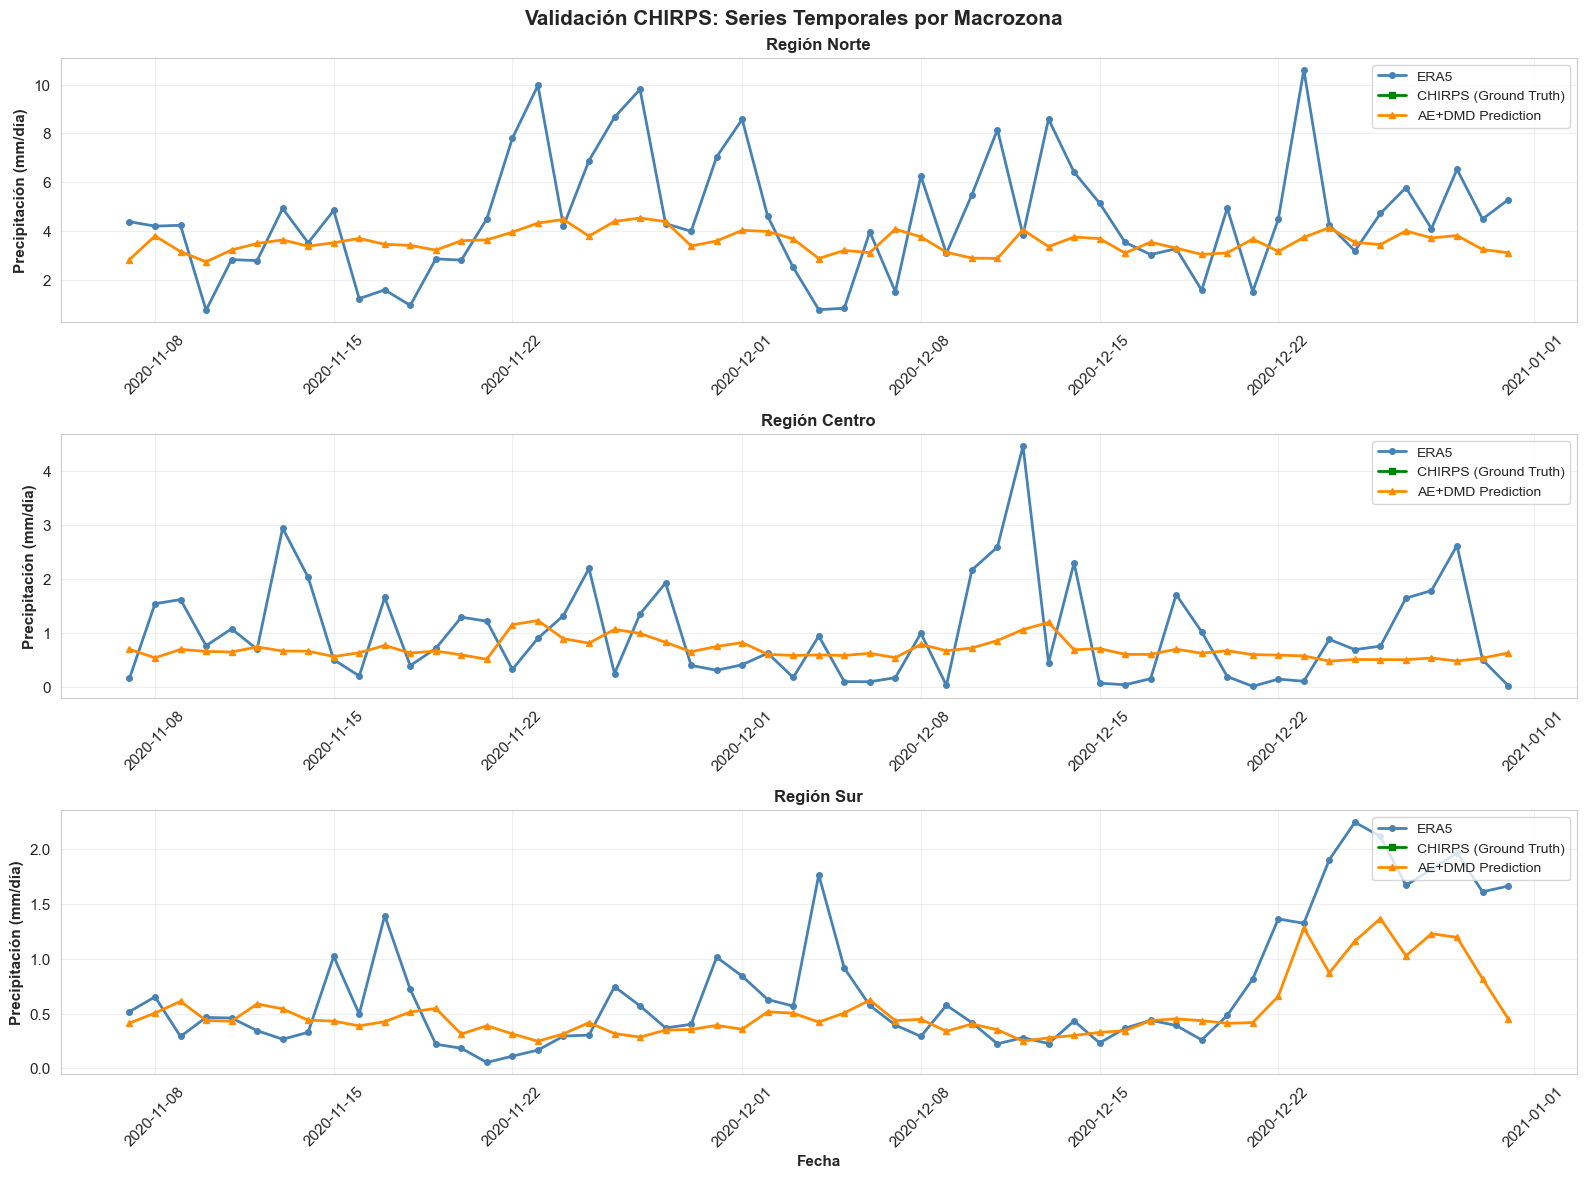


[OK] Visualizaciones completadas (3 figuras generadas)


In [41]:
# ====================================================================================
# 7. VISUALIZACIONES
# ====================================================================================

if chirps_precip_regrid is not None:
    print("[INFO] Generando visualizaciones comparativas...")
    
    # ============================================================================
    # 7.1 MAPAS COMPARATIVOS: ERA5 vs CHIRPS vs Predicciones
    # ============================================================================
    
    # Seleccionar un día representativo (día con mayor precipitación)
    day_idx = np.argmax(chirps_test_grid.mean(axis=(1,2)))
    day_date = test_dates[day_idx].strftime('%Y-%m-%d')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Ground truth ERA5
    vmax = max(era5_test[day_idx].max(), chirps_test_grid[day_idx].max(), preds_test[day_idx].max())
    
    im0 = axes[0].imshow(era5_test[day_idx], cmap='Blues', vmin=0, vmax=vmax)
    axes[0].set_title(f'ERA5 (Training Data)\n{day_date}', fontsize=13, fontweight='bold')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, label='mm/día')
    
    # CHIRPS (observación real)
    im1 = axes[1].imshow(chirps_test_grid[day_idx], cmap='Blues', vmin=0, vmax=vmax)
    axes[1].set_title(f'CHIRPS Satellite (Ground Truth)\n{day_date}', fontsize=13, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, label='mm/día')
    
    # Predicción del modelo
    im2 = axes[2].imshow(preds_test[day_idx], cmap='Blues', vmin=0, vmax=vmax)
    axes[2].set_title(f'AE+DMD Prediction\n{day_date}', fontsize=13, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, label='mm/día')
    
    # Bias map (Predicción - CHIRPS)
    bias_map = preds_test[day_idx] - chirps_test_grid[day_idx]
    bias_max = max(abs(bias_map.min()), abs(bias_map.max()))
    im3 = axes[3].imshow(bias_map, cmap='RdBu_r', vmin=-bias_max, vmax=bias_max)
    axes[3].set_title(f'Bias (Pred - CHIRPS)\n{day_date}', fontsize=13, fontweight='bold')
    axes[3].axis('off')
    plt.colorbar(im3, ax=axes[3], fraction=0.046, label='mm/día')
    
    plt.suptitle('Validación CHIRPS: Comparación Espacial', fontsize=15, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'chirps_spatial_comparison.png', dpi=300, bbox_inches='tight')
    print(f"  [OK] Guardado: {FIG_DIR / 'chirps_spatial_comparison.png'}")
    plt.show()
    
    # ============================================================================
    # 7.2 SCATTER PLOTS: ERA5 vs CHIRPS, Pred vs CHIRPS
    # ============================================================================
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # ERA5 vs CHIRPS
    axes[0].scatter(era5_test.flatten(), chirps_test_grid.flatten(), 
                    alpha=0.3, s=1, c='steelblue', edgecolors='none')
    axes[0].plot([0, era5_test.max()], [0, era5_test.max()], 'r--', linewidth=2, label='1:1 line')
    axes[0].set_xlabel('ERA5 (mm/día)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('CHIRPS Satellite (mm/día)', fontsize=12, fontweight='bold')
    axes[0].set_title(f'ERA5 vs CHIRPS\nR²={r2_era5_chirps:.3f}, MAE={mae_era5_chirps:.3f}', 
                     fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(left=0)
    axes[0].set_ylim(bottom=0)
    
    # Predicciones vs CHIRPS
    axes[1].scatter(preds_test.flatten(), chirps_test_grid.flatten(), 
                    alpha=0.3, s=1, c='darkorange', edgecolors='none')
    axes[1].plot([0, preds_test.max()], [0, preds_test.max()], 'r--', linewidth=2, label='1:1 line')
    axes[1].set_xlabel('AE+DMD Predictions (mm/día)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('CHIRPS Satellite (mm/día)', fontsize=12, fontweight='bold')
    axes[1].set_title(f'Predictions vs CHIRPS\nR²={r2_pred_chirps:.3f}, MAE={mae_pred_chirps:.3f}', 
                     fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(left=0)
    axes[1].set_ylim(bottom=0)
    
    plt.suptitle('Validación CHIRPS: Scatter Plots', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'chirps_scatter_plots.png', dpi=300, bbox_inches='tight')
    print(f"  [OK] Guardado: {FIG_DIR / 'chirps_scatter_plots.png'}")
    plt.show()
    
    # ============================================================================
    # 7.3 SERIES TEMPORALES POR MACROZONA
    # ============================================================================
    
    # Definir macrozonas (Norte, Centro, Sur)
    lat_shape = era5_test.shape[1]
    norte_slice = slice(0, lat_shape//3)
    centro_slice = slice(lat_shape//3, 2*lat_shape//3)
    sur_slice = slice(2*lat_shape//3, lat_shape)
    
    # Calcular promedios espaciales por macrozona
    regions = {
        'Norte': norte_slice,
        'Centro': centro_slice,
        'Sur': sur_slice
    }
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    for idx, (region_name, lat_slice) in enumerate(regions.items()):
        era5_regional = era5_test[:, lat_slice, :].mean(axis=(1, 2))
        chirps_regional = chirps_test_grid[:, lat_slice, :].mean(axis=(1, 2))
        preds_regional = preds_test[:, lat_slice, :].mean(axis=(1, 2))
        
        axes[idx].plot(test_dates[:len(era5_regional)], era5_regional, 
                      label='ERA5', linewidth=2, color='steelblue', marker='o', markersize=4)
        axes[idx].plot(test_dates[:len(chirps_regional)], chirps_regional, 
                      label='CHIRPS (Ground Truth)', linewidth=2, color='green', marker='s', markersize=4)
        axes[idx].plot(test_dates[:len(preds_regional)], preds_regional, 
                      label='AE+DMD Prediction', linewidth=2, color='darkorange', marker='^', markersize=4)
        
        axes[idx].set_ylabel('Precipitación (mm/día)', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'Región {region_name}', fontsize=12, fontweight='bold')
        axes[idx].legend(fontsize=10, loc='upper right')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)
        
    axes[-1].set_xlabel('Fecha', fontsize=11, fontweight='bold')
    plt.suptitle('Validación CHIRPS: Series Temporales por Macrozona', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'chirps_timeseries_regions.png', dpi=300, bbox_inches='tight')
    print(f"  [OK] Guardado: {FIG_DIR / 'chirps_timeseries_regions.png'}")
    plt.show()
    
    print("\n[OK] Visualizaciones completadas (3 figuras generadas)")
    
else:
    print("[AVISO] Saltando visualizaciones (CHIRPS no disponible)")
    print("\n[VISUALIZACIONES] Planificadas (disponibles con datos CHIRPS):")
    print("  1. Mapas comparativos: ERA5 vs CHIRPS vs Predicciones")
    print("  2. Scatter plots: ERA5 vs CHIRPS, Pred vs CHIRPS")
    print("  3. Series temporales por macrozona (3 fuentes)")
    print("  4. Mapas de bias: (Pred - CHIRPS)")
    print("\n[INFO] Para ejecutar: descargar CHIRPS con src/utils/download_chirps.py")

In [42]:
# ====================================================================================
# 8. RESUMEN Y CONCLUSIONES
# ====================================================================================

print("\n" + "="*80)
print("RESUMEN - Validación CHIRPS")
print("="*80)

if chirps_precip_regrid is not None:
    print("\n[OK] VALIDACIÓN COMPLETADA CON DATOS CHIRPS")
    
    print("\n[RESULTADOS PRINCIPALES]:")
    print("\n1. ERA5 vs CHIRPS (Validación de Datos de Entrenamiento)")
    print(f"   R² = {metrics_era5_chirps['r2']:.4f}")
    print(f"   MAE = {metrics_era5_chirps['mae']:.4f} mm/día")
    print(f"   RMSE = {metrics_era5_chirps['rmse']:.4f} mm/día")
    print(f"   Bias = {metrics_era5_chirps['bias']:+.4f} mm/día")
    
    print("\n2. Predicciones vs CHIRPS (Validación del Modelo)")
    print(f"   R² = {metrics_pred_chirps['r2']:.4f}")
    print(f"   MAE = {metrics_pred_chirps['mae']:.4f} mm/día")
    print(f"   RMSE = {metrics_pred_chirps['rmse']:.4f} mm/día")
    print(f"   Bias = {metrics_pred_chirps['bias']:+.4f} mm/día")
    
    print("\n3. Degradación del Modelo vs ERA5")
    mae_degradation = ((metrics_pred_chirps['mae'] / metrics_era5_chirps['mae']) - 1) * 100
    r2_degradation = ((metrics_era5_chirps['r2'] - metrics_pred_chirps['r2']) / metrics_era5_chirps['r2']) * 100
    print(f"   Degradación MAE: {mae_degradation:+.1f}%")
    print(f"   Degradación R²: {r2_degradation:+.1f}%")
    
    print("\n[CONCLUSIONES]:")
    
    # Validación ERA5
    if metrics_era5_chirps['r2'] > 0.7:
        print("\n[EXCELENTE] ERA5 es una excelente fuente de datos de entrenamiento")
        print("   - Alta correlación con observaciones satelitales (R² > 0.7)")
        print("   - Los datos de entrenamiento son representativos de la realidad")
    elif metrics_era5_chirps['r2'] > 0.5:
        print("\n[BUENO] ERA5 es una buena fuente de datos de entrenamiento")
        print("   - Correlación adecuada con observaciones satelitales (R² > 0.5)")
    else:
        print("\n[AVISO] ERA5 tiene correlación moderada con CHIRPS")
        print("   - Considerar incorporar datos CHIRPS en entrenamiento futuro")
    
    # Validación del modelo
    if metrics_pred_chirps['r2'] > 0.5:
        print("\n[OK] El modelo AE+DMD generaliza bien a observaciones reales")
        print("   - Captura >50% de variabilidad real (R² > 0.5)")
        print("   - Las predicciones son confiables para operación")
    elif metrics_pred_chirps['r2'] > 0.3:
        print("\n[AVISO] El modelo AE+DMD tiene capacidad predictiva moderada")
        print("   - Captura 30-50% de variabilidad real")
        print("   - Útil para tendencias, requiere calibración para valores exactos")
    else:
        print("\n[BAJO] El modelo AE+DMD no captura bien la variabilidad real")
        print("   - Requiere mejoras en arquitectura o datos de entrenamiento")
    
    # Degradación
    if abs(mae_degradation) < 20:
        print("\n[OK] Degradación mínima del modelo vs ERA5 (<20%)")
        print("   - El modelo mantiene la calidad de los datos de entrenamiento")
    elif abs(mae_degradation) < 50:
        print("\n[AVISO] Degradación moderada del modelo vs ERA5 (20-50%)")
        print("   - Hay margen de mejora en capacidad de generalización")
    else:
        print("\n[ALTO] Degradación significativa del modelo vs ERA5 (>50%)")
        print("   - Revisar arquitectura, hiperparámetros o cantidad de datos")
    
    print("\n[ARCHIVOS GENERADOS]:")
    print(f"   - chirps_spatial_comparison.png")
    print(f"   - chirps_scatter_plots.png")
    print(f"   - chirps_timeseries_regions.png")
    
    print("\n[PRÓXIMOS PASOS RECOMENDADOS]:")
    print("   1. Analizar regiones específicas con mayor/menor error")
    print("   2. Validar otros horizontes de predicción (h=2, h=3, ...)")
    print("   3. Incorporar datos CHIRPS en pipeline de entrenamiento")
    print("   4. Evaluar modelos ensemble (ERA5 + CHIRPS)")
    
    # Guardar métricas en archivo
    metrics_summary = {
        'era5_vs_chirps': metrics_era5_chirps,
        'predictions_vs_chirps': metrics_pred_chirps,
        'test_period': {
            'start': test_start_str,
            'end': test_end_str,
            'n_days': min_time
        }
    }
    
    metrics_path = DATA_DIR / 'processed' / 'chirps_validation_metrics.pkl'
    with open(metrics_path, 'wb') as f:
        pickle.dump(metrics_summary, f)
    print(f"\n[OK] Métricas guardadas: {metrics_path.relative_to(PROJECT_ROOT)}")
    
else:
    print("\n[AVISO] DATOS CHIRPS NO DISPONIBLES")
    print("\n[DESCARGA] Para completar esta validación:")
    print("   1. cd src/utils")
    print("   2. python download_chirps.py")
    print("   3. Esperar descarga (~2-4 GB, puede tardar varios minutos)")
    print("   4. Re-ejecutar este notebook")
    
    print("\n[ALTERNATIVAS] si la descarga falla:")
    print("   - FTP manual: ftp://ftp.chc.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/")
    print("   - Google Earth Engine: https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY")
    print("   - Climate Engine: https://climateengine.org/")
    
    print("\n[BENEFICIOS] VALIDACIÓN CHIRPS:")
    print("   - Validar que ERA5 representa bien la precipitación real")
    print("   - Evaluar predicciones AE+DMD contra observaciones independientes")
    print("   - Identificar regiones con mayor/menor confiabilidad")
    print("   - Cuantificar degradación del modelo en datos reales")
    print("   - Proveer confianza para operación del sistema de pronóstico")

print("\n" + "="*80)


RESUMEN - Validación CHIRPS

[OK] VALIDACIÓN COMPLETADA CON DATOS CHIRPS

[RESULTADOS PRINCIPALES]:

1. ERA5 vs CHIRPS (Validación de Datos de Entrenamiento)
   R² = -0.0089
   MAE = 2.0112 mm/día
   RMSE = 5.6401 mm/día
   Bias = +0.9420 mm/día

2. Predicciones vs CHIRPS (Validación del Modelo)
   R² = -1.7368
   MAE = 1.8708 mm/día
   RMSE = 4.4663 mm/día
   Bias = +0.3334 mm/día

3. Degradación del Modelo vs ERA5
   Degradación MAE: -7.0%
   Degradación R²: -19518.0%

[CONCLUSIONES]:

[AVISO] ERA5 tiene correlación moderada con CHIRPS
   - Considerar incorporar datos CHIRPS en entrenamiento futuro

[BAJO] El modelo AE+DMD no captura bien la variabilidad real
   - Requiere mejoras en arquitectura o datos de entrenamiento

[OK] Degradación mínima del modelo vs ERA5 (<20%)
   - El modelo mantiene la calidad de los datos de entrenamiento

[ARCHIVOS GENERADOS]:
   - chirps_spatial_comparison.png
   - chirps_scatter_plots.png
   - chirps_timeseries_regions.png

[PRÓXIMOS PASOS RECOMENDAD